# Rainbow!

## Initialization, imports

In [1]:
NB_ID = '08'

import gymnasium as gym
from gymnasium.wrappers.record_video import RecordVideo

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_

import numpy as np
import random
import math
import matplotlib.pyplot as plt
from plot_util import colorline

from IPython.display import clear_output

from typing import Dict, List, Tuple, Deque
from collections import deque
from segment_tree import SumSegmentTree, MinSegmentTree


plt.ion()

## N-step replay buffer

In [2]:
class ReplayBuffer:
    # obs_size = state/observable space size
    def __init__(
        self, 
        max_size: int, 
        obs_size: int, 
        batch_size:int=32,
        n_step: int = 3,
        gamma: float = 0.99,
    ):
        self.state_buf = np.zeros((max_size, obs_size), dtype=np.float32)
        self.action_buf = np.zeros(max_size, dtype=np.float32)
        self.reward_buf = np.zeros(max_size, dtype=np.float32)
        self.ns_buf = np.zeros((max_size, obs_size), dtype=np.float32)
        self.done_buf = np.zeros(max_size, dtype=np.float32)

        self.max_size, self.batch_size = max_size, batch_size
        self.ptr, self.size = 0, 0

        self.n_step_buffer = deque(maxlen=n_step)
        self.n_step = n_step
        self.gamma = gamma

    def push(self, 
        state: np.ndarray, 
        action: int, 
        reward: float, 
        ns: np.ndarray, 
        done: bool,
    ):
        transition = (state, action, reward, ns, done)
        self.n_step_buffer.append(transition)

        if len(self.n_step_buffer) < self.n_step:
            # we don't have to flush the n_step buffer or anything like that
            # because it's a deque. see: https://www.geeksforgeeks.org/deque-in-python/
            return ()

        # at this point, we're now storing n-step transitions into memory
        reward, ns, done = self._get_n_step_info(
            self.n_step_buffer, self.gamma
        )

        # pair rew, n_s, done with a state and action that are at the start the chain
        state, action = self.n_step_buffer[0][:2]

        idx = self.ptr

        self.state_buf[idx] = state
        self.action_buf[idx] = action
        self.reward_buf[idx] = reward
        self.ns_buf[idx] = ns
        self.done_buf[idx] = done
        
        self.ptr = (idx + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

        return self.n_step_buffer[0]
    
    def sample(self) -> Dict[str, np.ndarray]:
        idxs = random.sample(range(self.size), self.batch_size)
        return dict(
            state=self.state_buf[idxs],
            action=self.action_buf[idxs],
            reward=self.reward_buf[idxs],
            ns=self.ns_buf[idxs],
            done=self.done_buf[idxs],
            idxs=idxs,
        )

    def sample_from_idxs(self, idxs: np.ndarray) -> Dict[str, np.ndarray]:
        return dict(
            state=self.state_buf[idxs],
            action=self.action_buf[idxs],
            reward=self.reward_buf[idxs],
            ns=self.ns_buf[idxs],
            done=self.done_buf[idxs],
            idxs=idxs,
        )

    def _get_n_step_info(
        self, n_step_buffer: Deque, gamma: float
    ):
        rew, next_state, done = n_step_buffer[-1][2:]

        # we calculate it backwards
        # this does not create correlations between different training sessions,
        # because by multiplying by (1-done) we mask the following training session anyway
        for transition in reversed(list(n_step_buffer)[:-1]):
            r, n_s, d = transition[2:]

            rew = r + self.gamma * (1-done) * rew
            # if our episode ends before this "chain" does, then next_state will be
            # the ending state, rather than that of the end of this chain of steps.
            next_state, done = (n_s, d) if d else (next_state, done)

        return rew, next_state, done

    def __len__(self):
        return self.size

## Prioritized replay buffer

In [3]:
class PrioritizedReplayBuffer(ReplayBuffer):
    def __init__(
        self,
        max_size: int,
        obs_rank: int,
        batch_size: int = 32,
        alpha: float = 0.6,
        n_step: int = 1,
        gamma: float = 0.99,
    ):
        assert alpha >= 0

        super().__init__(max_size, obs_rank, batch_size, n_step, gamma)
        self.max_priority, self.tree_ptr = 1.0, 0
        self.alpha = alpha

        tree_capacity = 1
        # tree_capacity will end up larger than max_size
        while tree_capacity < self.max_size:
            tree_capacity *= 2

        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)
    
    def push(
        self,
        obs: np.ndarray,
        act: int,
        rew: float,
        next_obs: np.ndarray,
        done: bool
    ):
        super().push(obs, act, rew, next_obs, done)

        # we are gonna "interlace" the two to calculate the TD error
        self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
        # NOTE: I thought min_tree was a weird way to operate, but it only makes
        # sense because you want bias corrections to occur across the whole training,
        # not just one batch.
        self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha
        self.tree_ptr = (self.tree_ptr + 1) % self.max_size

    def sample(self, beta: float = 0.4) -> Dict[str, np.ndarray]:
        assert len(self) >= self.batch_size
        assert beta > 0

        # indices (plural)
        idx = self._sample_proportional()

        return dict(
            state=self.state_buf[idx],
            action=self.action_buf[idx],
            reward=self.reward_buf[idx],
            ns=self.ns_buf[idx],
            done=self.done_buf[idx],
            weight=np.array([self._calculate_weight(i, beta) for i in idx]),
            idx=idx,
        )

    def _sample_proportional(self) -> List[int]:
        # we do all of this even though we could use the random package's 
        # weighted samples method, because we need to be EFFICIENT in computation.
        indices = []
        # we insert end here because the size of our 
        # memory will be smaller than the tree
        # NOTE: I think it wold be fine if we ommitted these parameters,
        # if we initialize the tree with values 0
        p_total = self.sum_tree.sum(start=0, end=len(self) - 1)
        # divide total td sum over each batch
        segment = p_total / self.batch_size

        # the idea here is that the range a to b will cover ALL samples
        # one iteration at a time, that is, one segment at a time
        for i in range(self.batch_size):
            a = segment * i
            b = segment * (i + 1)
            upperbound = random.uniform(a, b)
            # because we ranked higher values first, we will retrieve
            # the 1st sample a couple times, 2nd sample a couple times less, and so on
            # basically, a Power law distribution
            idx = self.sum_tree.find_prefixsum_idx(upperbound)
            indices.append(idx)

        return indices

    def _calculate_weight(self, idx: int, beta:float):
        # get lowest probability, hence the max weight
        # check paper for details
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * len(self)) ** (-beta)

        p_idx = self.min_tree[idx] / self.sum_tree.sum()
        weight = (p_idx * len(self)) ** (-beta)
        weight = weight / max_weight
        return weight

    def update_priorities(self, indices: List[int], priorities:np.ndarray):
        assert len(indices) == len(priorities)

        for idx, priority in zip(indices, priorities):
            assert priority > 0
            assert 0 <= idx < len(self)

            # will be used for $P(i)=\frac{p(i)^\alpha}{\sum_k{p(k)^\alpha}}$
            # I don't think there'd be any other way to implement this other than when we store it
            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha

            self.max_priority = max(self.max_priority, priority)

## Noisy layer

In [4]:
class NoisyLinear(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        std_init: float = 0.5
    ):
        super().__init__()
      
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.Tensor(out_features, in_features))
        # https://discuss.pytorch.org/t/what-is-the-difference-between-register-buffer-and-register-parameter-of-nn-module/32723/2
        # register something on state_dict but DON'T make it a learnable parameter
        self.register_buffer(
            'weight_epsilon', torch.Tensor(out_features, in_features)
        )

        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))
        self.register_buffer(
            'bias_epsilon', torch.Tensor(out_features)
        )

        # initialize parameters & noise
        with torch.no_grad():
            self.reset_parameters()
            self.reset_noise()

    def reset_parameters(self):
        """Initialize/reset learnable parameters"""
        
        '''
        NOTE: by default, nn.Linear initializes both weights and parameters
        from a uniform distribution bounded by [-sqrt(in_features), sqrt(in_features)]
        more on https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
        NOTE: this is different from the original tutorial because I used
        `torch.no_grad()` rather than `Tensor.data.(...)`
        more on https://discuss.pytorch.org/t/which-copy-is-better/56393/2
        '''
        # mu - noise "bias"
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        # sigma - noise weight 
        # TODO: experiment with uniform distribution of sigma too
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.in_features))
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.out_features))

    def reset_noise(self):
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)

        # outer product
        self.weight_epsilon.copy_(epsilon_out.outer(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.linear(
            x,
            self.weight_mu + self.weight_sigma * self.weight_epsilon,
            self.bias_mu + self.bias_sigma * self.bias_epsilon
        )

    @staticmethod
    def scale_noise(size: int) -> torch.Tensor:
            x = torch.randn(size)
            # x = sgn(x) * sqrt(|x|)
            return x.sign().mul(x.abs().sqrt())

## Network (noisy + dueling + categorical)

In [5]:
class Network(nn.Module):
    def __init__(
        self, 
        obs_size: int, 
        action_size: int,
        atom_n: int,
        support: torch.Tensor,
    ):
        super().__init__()
        self.atom_n = atom_n
        self.action_size = action_size
        self.support = support

        self.feature_layer = nn.Sequential(
            nn.Linear(obs_size, 128),
            nn.ReLU(),
        )

        self.advantage_hidden_layer = NoisyLinear(128, 128)
        self.advantage_layer = NoisyLinear(128, action_size * atom_n)

        self.value_hidden_layer = NoisyLinear(128, 128)
        self.value_layer = NoisyLinear(128, atom_n)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        dist = self.dist(x)
        q = torch.sum(dist * self.support, dim=-1)

        return q

    def dist(self, x):
        features = self.feature_layer(x)
        
        adv_hid = F.relu(self.advantage_hidden_layer(features))
        adv = F.relu(self.advantage_layer(adv_hid)).view(-1, self.action_size, self.atom_n)

        val_hid = F.relu(self.value_hidden_layer(features))
        val = F.relu(self.value_layer(val_hid)).view(-1, 1, self.atom_n)

        q_atoms = val + adv - adv.mean(dim=-1, keepdim=True)
        q_dist = q_atoms.softmax(dim=-1)
        q_dist = q_dist.clamp(min=1e-3)

        return q_dist

    def reset_noise(self):
        self.advantage_hidden_layer.reset_noise()
        self.advantage_layer.reset_noise()
        self.value_hidden_layer.reset_noise()
        self.value_layer.reset_noise()

## Agent

In [6]:
class DQNAgent:
    def __init__(self,
        env: gym.Env,
        seed: int,
        memory_size: int,
        batch_size: int,
        target_update: int,
        eps_decay: float,
        max_eps: float = .9,
        min_eps: float = .1,
        gamma: float = .99,

        # PER
        alpha: float = 0.2,
        beta: float = 0.6,
        prior_eps: float = 1e-6,
        # categorical
        v_min: float = 0.0,
        v_max: float = 200.0,
        atom_n: int = 51,
        # N-step
        n_step: int = 3,
    ):
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )

        self.env = env
        self.seed = seed
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.target_update = target_update
        self.eps_decay = eps_decay
        self.eps = max_eps
        self.max_eps = max_eps
        self.min_eps = min_eps
        self.gamma = gamma
        obs_size = env.observation_space.shape[0]
        action_size = env.action_space.n

        # PER
        self.beta = beta
        self.prior_eps = prior_eps
        self.memory = PrioritizedReplayBuffer(
            memory_size, obs_size, batch_size, alpha
        )

        # N-step
        self.use_n_step = True if n_step > 1 else False
        if self.use_n_step:
            self.n_step = n_step
            self.n_memory = ReplayBuffer(
                memory_size, obs_size, batch_size, n_step, gamma
            )

        # categorical
        self.v_min = v_min
        self.v_max = v_max
        self.atom_n = atom_n
        self.support = torch.linspace(v_min, v_max, self.atom_n).to(self.device)
        
        self.dqn = Network(obs_size, action_size, atom_n, self.support).to(self.device)
        self.dqn_target = Network(obs_size, action_size, atom_n, self.support).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        self.optimizer = optim.AdamW(self.dqn.parameters(), amsgrad=True)

        self.transition = []

        self.is_test = False

        self.eff_episode = 0

    def choose_action(self, state: np.ndarray) -> int:
        selected_action = self.dqn(torch.FloatTensor(state, device=self.device))
        selected_action = selected_action.argmax().item()
        if not self.is_test:
            self.transition = [state, selected_action]
        return selected_action
    
    def take_step(self, action: int) -> Tuple[np.ndarray, np.float64, bool]:
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        
        if not self.is_test:
            self.transition += [reward, next_state, done]
            if self.use_n_step:
                one_step_transition = self.n_memory.push(*self.transition)
            else:
                one_step_transition = self.transition
            
            if one_step_transition:
                self.memory.push(*one_step_transition)

        return next_state, reward, done
    
    def compute_dqn(self, samples: dict[str, np.array], gamma: float):
        """calculate the DQN loss for a batch of memories"""
        # we take in a gamma argument, because our samples may or may not be
        # n-step samples

        device = self.device
        # each of these is a batch/samples of their corresponding name
        state = torch.FloatTensor(samples["state"], device=device)
        ns = torch.FloatTensor(samples["ns"], device=device)
        action = torch.LongTensor(samples["action"], device=device)
        reward = torch.FloatTensor(samples["reward"], device=device).reshape(-1, 1)
        done = torch.FloatTensor(samples["done"], device=device).reshape(-1, 1)

        delta_z = float(self.v_max - self.v_min) / (self.atom_n - 1)

        with torch.no_grad():
            next_action = self.dqn(ns).argmax(-1)
            next_dist = self.dqn_target.dist(ns)
            # filter for the dists we want (e.g. with largest sum)
            # we don't use gather here because pytorch would require idx tensor to have same shape as src, we ain't got time 4 that
            # next_dist = next_dist.gather(-1, next_action.unsqueeze(-1))
            next_dist = next_dist[range(self.batch_size), next_action]

            # t_z basically denotes where some atom i is horizontally positioned in a bar graph
            # in this case, we contract it towards 0 (* self.gamma) and shift it right if positive (+ reward)
            t_z = reward + (1-done) * gamma * self.support
            # clamp it (surprised we do this now and not later)
            t_z = t_z.clamp(min=self.v_min, max=self.v_max)
            # shift left by v_min (we take it that all probs. will start at v_min)
            # at this point we're asking "for an atom i, to what atom do you map on the target distribution?"
            # some values may not be integers, like 3.7
            b = (t_z - self.v_min) / delta_z
            # so we get the floor and ceil so we can later calculate how much of an atom projects to the target atom.
            # e.g., t_z[i] = 3.7; 70% (u-b) will go to atom 3, 30% to atom 4 of target distribution
            l = b.floor().long()
            u = b.ceil().long()

            '''
            this is maybe the weirdest thing here. We do this instead of iterating through each batch item
            presumably because it performs better. but yeah this is just so we later iterate through collections of
            atoms. It has this format:
            [[0, 0, ...batch_size], [1*deltaZ, 1*deltaZ, ...batch_size], [2*deltaZ, 2*deltaZ, ...batch_size]]
            where deltaZ is the span between one atom to the other.
            hence, its shape is [atom_n, batch_size]
            '''
            offset = (torch.linspace(
                0, (self.batch_size - 1) * self.atom_n, self.batch_size, device=self.device
                ).long()
                # [[1], [2], [n]]]
                .unsqueeze(1)
                # [[1, 1, 1], [2, 2, 2], [n, n, n]] (for atom_n=3)
                .expand(-1, self.atom_n)
            )

            proj_dist = torch.zeros(next_dist.size(), device=self.device)
            # we now project the current atoms onto a target discrete support
            proj_dist.view(-1).index_add_(
                0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1)
            )
            proj_dist.view(-1).index_add_(
                0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1)
            )

        dist = self.dqn.dist(state)
        # Wasserstein distance
        log_p = torch.log(dist[range(self.batch_size), action])

        elementwise_loss = -(proj_dist * log_p).sum(1)


        # # for debugging!
        # if self.eff_episode % 100 == 0:
            # print('state', state[:2])
            # print('ns', ns[:2])
            # print('act', action[:2])
            # print('rew', reward[:2])
            # print('done', done[:2])
            # print('curr_q', curr_q_value[:2])
            # print('next_q', next_q_value[:2])
            # print('target', target[:2])

        with torch.no_grad():
            returns = self.dqn(state)
            mean_return = returns.mean().detach().item()

        return elementwise_loss, mean_return
        
    def update_model(self) -> float:
        samples = self.memory.sample(self.beta)
        weights = torch.FloatTensor(samples['weight']).reshape(-1, 1).to(self.device)
        indices = samples['idx']

        elementwise_loss, q_value = self.compute_dqn(samples, self.gamma)

        # loss = torch.mean(elementwise_loss * weights)

        # combine 1-step and n-step by accumulating n-step losses onto 1-step losses
        if self.use_n_step:
            n_samples = self.n_memory.sample_from_idxs(indices)
            gamma = self.gamma ** self.n_step
            elementwise_n_loss, n_q_value = self.compute_dqn(n_samples, gamma)
            elementwise_loss += elementwise_n_loss

        # we have the loss for each sample -- now weight it
        loss = torch.mean(elementwise_loss * weights)

        q_val = (q_value + n_q_value) / 2

        # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        self.optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(self.dqn.parameters(), 10.0)
        self.optimizer.step()

        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.prior_eps
        self.memory.update_priorities(indices, new_priorities)

        self.dqn.reset_noise()
        self.dqn_target.reset_noise()

        return loss.item(), q_val

    def train(self, seed: int, num_frames: int, plotting_interval: int=200):
        try:
            self.is_test = False

            state, _ = self.env.reset(seed=seed)
            # effective episode - n. of episodes after initial "memory gathering"
            total_episodes = 0
            self.eff_episode = 0
            score = 0
            scores = []
            losses = []
            epsilons = []
            predictions = []
            
            for frame_idx in range(1, num_frames + 1):
                action = self.choose_action(state)
                next_state, reward, done = self.take_step(action)

                state = next_state
                score += reward

                # progress = frame_idx / num_frames
                progress = min(frame_idx / num_frames, 1.0)
                self.beta = self.beta + progress * (1.0 - self.beta)

                if done:
                    total_episodes += 1
                    state, _ = self.env.reset(seed=seed+total_episodes)
                    scores.append(score)
                    score = 0
                if len(self.memory) >= self.batch_size:
                    loss, curr_q_value = self.update_model()
                    losses.append(loss)
                    predictions.append(curr_q_value)
                    self.eff_episode += 1
                    # linear decay
                    self.eps = max(self.min_eps, self.eps - (self.max_eps - self.min_eps) * self.eps_decay)
                    epsilons.append(self.eps)

                    if self.eff_episode % self.target_update == 0:
                        self.target_hard_update()

                if frame_idx % plotting_interval == 0:
                    self._plot(frame_idx, scores, losses, epsilons, predictions)
        except KeyboardInterrupt:
            self.save_state()
        else:
            self.save_state('saved-state-done')
        self.env.close()
    
    def save_state(self, name='saved-state'):
        state_dict = self.dqn.state_dict()
        torch.save(state_dict, f'saved-states/{NB_ID}.s{self.seed}.pt')
        return state_dict

    def load_state(self, state_dict):
        self.dqn.load_state_dict(state_dict)
        return state_dict
        
    def test(self, video_folder: str):
        self.is_test = True
        # save current environment to swap it back later on
        naive_env = self.env
        
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder, name_prefix=NB_ID)
        state, _ = self.env.reset()
        self.env.start_video_recorder()
        done = False
        score = 0
        while not done:
            action = self.choose_action(state)
            next_state, reward, done = self.take_step(action)

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

        self.env = naive_env

    def target_hard_update(self):
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def _plot(self, frame_idx, scores, losses, epsilons, predictions):

        clear_output(wait=True)
        # taking a lil different path from the tutorial
        # https://stackoverflow.com/questions/37970424/what-is-the-difference-between-drawing-plots-using-plot-axes-or-figure-in-matpl
        # https://matplotlib.org/stable/_images/anatomy.png
        fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 5), num=1, clear=True)

        ax1.set_title(f'frame {frame_idx} | score: {np.mean(scores[-10:])}')
        
    
        """
        http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
        http://matplotlib.org/examples/pylab_examples/multicolored_line.html
        """

        # [0, 1, ..., len(scores)-1]
        # I feel like this is a bit expensive -- do it later down the training
        if len(scores) > 100:
            x = np.linspace(0, len(scores)-1, len(scores))
            y = scores
            # color scores into rainbow
            lc = colorline(ax1, x, y, cmap='hsv')
            ax1.set_xlim(0, len(scores)-1)
            ax1.set_ylim(0, np.max(scores))
            # add back padding
            ax1.autoscale()
        else:
            ax1.plot(scores)
        
        ax2.set_title('loss')
        ax2.plot(losses)

        ax3.set_title('mean Q value')
        ax3.plot(predictions)
        
        plt.show()


## Initializing environment

In [7]:
env_id = "CartPole-v1"
env = gym.make(env_id)

## Seeding

In [8]:
seed = 111

def seed_torch(seed):
    torch.manual_seed(seed)
    # https://pytorch.org/docs/stable/notes/randomness.html#cuda-convolution-benchmarking
    if torch.backends.cudnn.enabled:
        # this will make our model run the same across multiple executions,
        # at the cost of performance
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)

## Initializing agent
different from the other noteboks:
- memory_size: 1,000 -> 10,000
- batch_size: 32 -> 128

In [9]:
num_frames = 20_000
memory_size = 10_000
batch_size = 128
target_update = 100
epsilon_decay = 1/2000

agent = DQNAgent(env, seed, memory_size, batch_size, target_update, epsilon_decay)

## Training

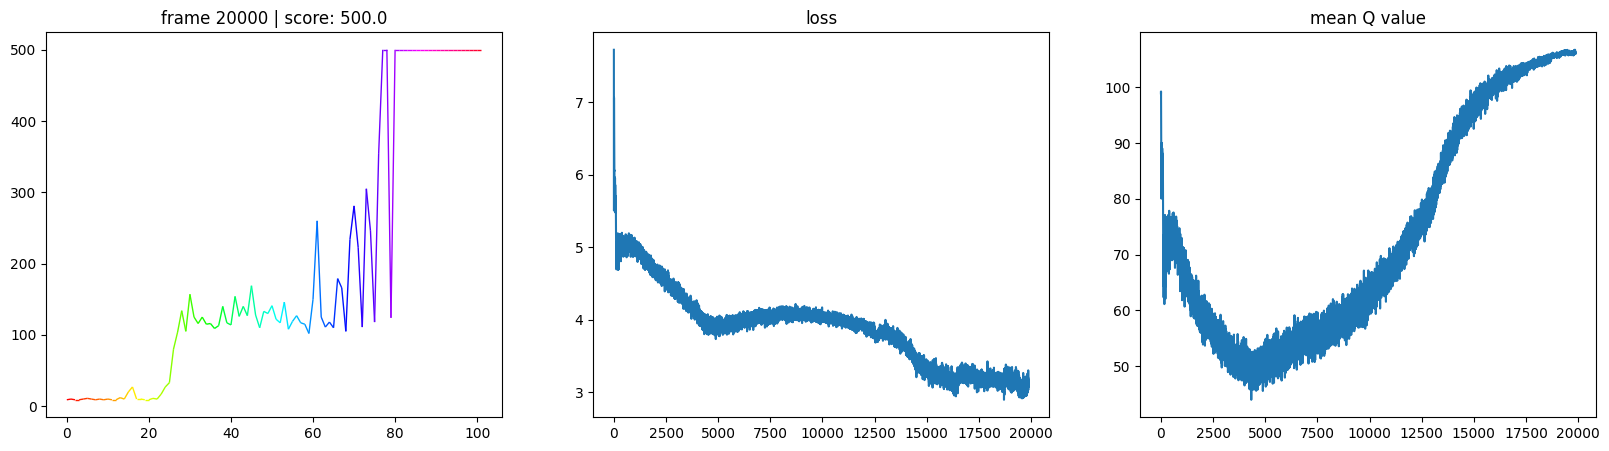

In [10]:
agent.train(seed, num_frames)

## Testing

In [11]:
video_folder = 'videos'
env_w_video = gym.make(env_id, render_mode="rgb_array")
# NOTE: epsilon is disabled while testing
agent = DQNAgent(env_w_video, seed, memory_size, batch_size, target_update, epsilon_decay)
saved_sd = torch.load(f'saved-states/{NB_ID}.s{seed}.pt') 
agent.load_state(saved_sd)
agent.test(video_folder)

d:\local\software\Python\Python311\Lib\site-packages\gymnasium\wrappers\record_video.py:87: UserWarning: WARN: Overwriting existing videos at d:\projects\programming\py\ml\rainbow\src\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\projects\programming\py\ml\rainbow\src\videos\08-episode-0.mp4.
Moviepy - Writing video d:\projects\programming\py\ml\rainbow\src\videos\08-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\projects\programming\py\ml\rainbow\src\videos\08-episode-0.mp4


Moviepy - Building video d:\projects\programming\py\ml\rainbow\src\videos\08-episode-0.mp4.
Moviepy - Writing video d:\projects\programming\py\ml\rainbow\src\videos\08-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\projects\programming\py\ml\rainbow\src\videos\08-episode-0.mp4
score:  500.0


## Preview

In [12]:
import base64
import io
import os

from IPython.display import HTML, display

def ipython_show_video(path):
    assert os.path.isfile(path), "path inaccessible"

    video = io.open(path, 'r+b').read()
    encoded = base64.b64encode(video)

    display(HTML(data=f"""
        <video height="240" alt="test video" controls>
        <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4"/>
        </video>
    """))

ipython_show_video(f'./videos/{NB_ID}-episode-0.mp4')